Data preprocessing :
<br>
Two data sources will be imported <br>
-"AIS_weather_h_rename_copy.csv" will be used to replace the information for true current direction and true wind direction <br>
-The resulting dataframe will be merged with the dataframe from the "AIS_weather_H_ok2_copy.csv" <br>
-The data of the journey between Ronne and Sassnitz will be omitted <br>
-The threshold for the ships manouvering speed will be 5kt (Abebe) <br>

In [250]:
import pandas as pd
from matplotlib import pyplot
import numpy as np
import seaborn as sns
import math
import datetime
import pickle
import joblib

dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
dfmain = dfmain[dfmain['LAT'] > 55.04 ]

dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
dfpre = dfpre[dfpre['LAT'] > 55.04 ]



In [251]:
dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfpre.head(n=5)

,eastwind,northwind,eastcurrent,northcurrent,sog,cog
0,2.267688,6.741482,0.113690,0.044994,0.0,358.9
1,1.782681,6.410275,0.113690,0.044994,0.0,358.9
2,1.154659,6.385135,0.083984,0.054000,0.0,358.9
3,0.348801,6.094659,0.083984,0.054000,0.0,358.9
4,-0.593128,6.153186,0.083984,0.054000,0.0,358.9


In [252]:
dfpre["True North Wind Direction"] = np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))

In [253]:
dfpre["True North Current Direction"] = np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))

In [254]:
dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','sog','cog'],axis=1)

In [255]:
df = pd.concat([dfmain,dfpre],axis=1)
df.head()

,Unnamed: 0,Time,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,...,Heading,Wind Speed,Current Speed,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,True North Wind Direction,True North Current Direction
0,0,2021-01-01 00:00:00,14.689663,55.098452,277.311035,1.259323,1.893614,4.818881,3.818459,4.154329,...,174.0,7.112664,0.122270,155.408180,105.591753,22.854050,22.749664,22.610062,18.591820,68.408246
1,1,2021-01-01 01:00:00,14.689659,55.098451,277.328369,1.259985,1.752303,4.755800,3.470216,4.130580,...,174.0,6.653538,0.122270,158.458891,105.591753,26.122772,19.152008,22.209274,15.541109,68.408246
2,2,2021-01-01 02:00:00,14.689648,55.098468,277.390625,1.260244,1.619775,4.645083,3.259682,4.083755,...,174.0,6.488697,0.099846,163.749663,116.740448,28.498383,12.424912,20.857971,10.250337,57.259552
3,3,2021-01-01 03:00:00,14.689646,55.098471,277.411377,1.260148,1.518736,4.588384,3.177906,4.010502,...,174.0,6.104632,0.099846,170.724504,116.740448,29.956985,6.725922,18.732071,3.275496,57.259552
4,4,2021-01-01 04:00:00,14.689644,55.098462,277.430664,1.260634,1.455034,4.528841,3.281654,3.913362,...,174.0,6.181707,0.099846,179.505940,116.740448,34.486298,3.761627,15.731430,-5.505940,57.259552


In [256]:
# SOG threshold according to Abebe
df = df[df['SOG'] > 5 ]

In [257]:
# Exclude data for the month of June to check the model's forecasting performance 
dfdate6 = df[df['Time'].dt.strftime('%Y-%m') == '2021-06']
df = df[df['Time'].dt.strftime('%Y-%m') != '2021-06']

In [258]:
# Temporary export
# df.to_csv("AIS_sog_threshold.csv")

Data Analysis before modelling 

In [259]:
df_ship = df.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
                    'Surface pressure','Width','Length'],axis=1)
df_ship.head(n=5)

,Temperature above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,Combined wind waves and swell height,Swell height,Wind wave height,Draught,...,Heading,Wind Speed,Current Speed,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,True North Wind Direction,True North Current Direction
8,276.900391,1.661038,4.291309,3.667458,3.757862,279.699585,0.865413,0.323892,0.801956,5.017723,...,269.900574,7.648595,0.104064,91.133175,143.029898,82.454986,91.138748,90.495209,1.033749,52.930471
9,276.705566,1.501637,4.187211,3.145607,3.803910,279.820312,0.785675,0.452440,0.578049,5.019207,...,300.130435,6.700397,0.104050,68.884377,96.351303,134.548587,115.015200,120.971331,9.014812,36.481737
10,276.309815,1.235528,4.012717,2.120399,3.819602,NaN,0.654636,0.556525,0.236435,5.019664,...,230.117302,4.089472,0.092759,129.989203,174.697284,59.296837,47.905998,52.498604,0.106505,44.814586
11,276.399902,1.204397,4.020009,2.090308,3.820546,NaN,0.638782,0.555405,0.226181,5.019009,...,178.653615,3.821501,0.093128,170.879672,107.951765,8.221531,10.314571,1.236454,7.773943,70.701850
12,277.134033,1.275907,4.095175,3.029945,3.815268,279.820312,0.674081,0.598373,0.263031,5.020452,...,125.446296,5.479353,0.086621,102.327505,72.665715,47.977150,68.470208,54.270195,23.118792,52.780582


In [260]:
df_ship2 = df_ship.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [261]:
# Scaling script if necessary

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df_ship2 = pd.DataFrame(scaler.fit_transform(df_ship2),columns=df_ship2.columns)


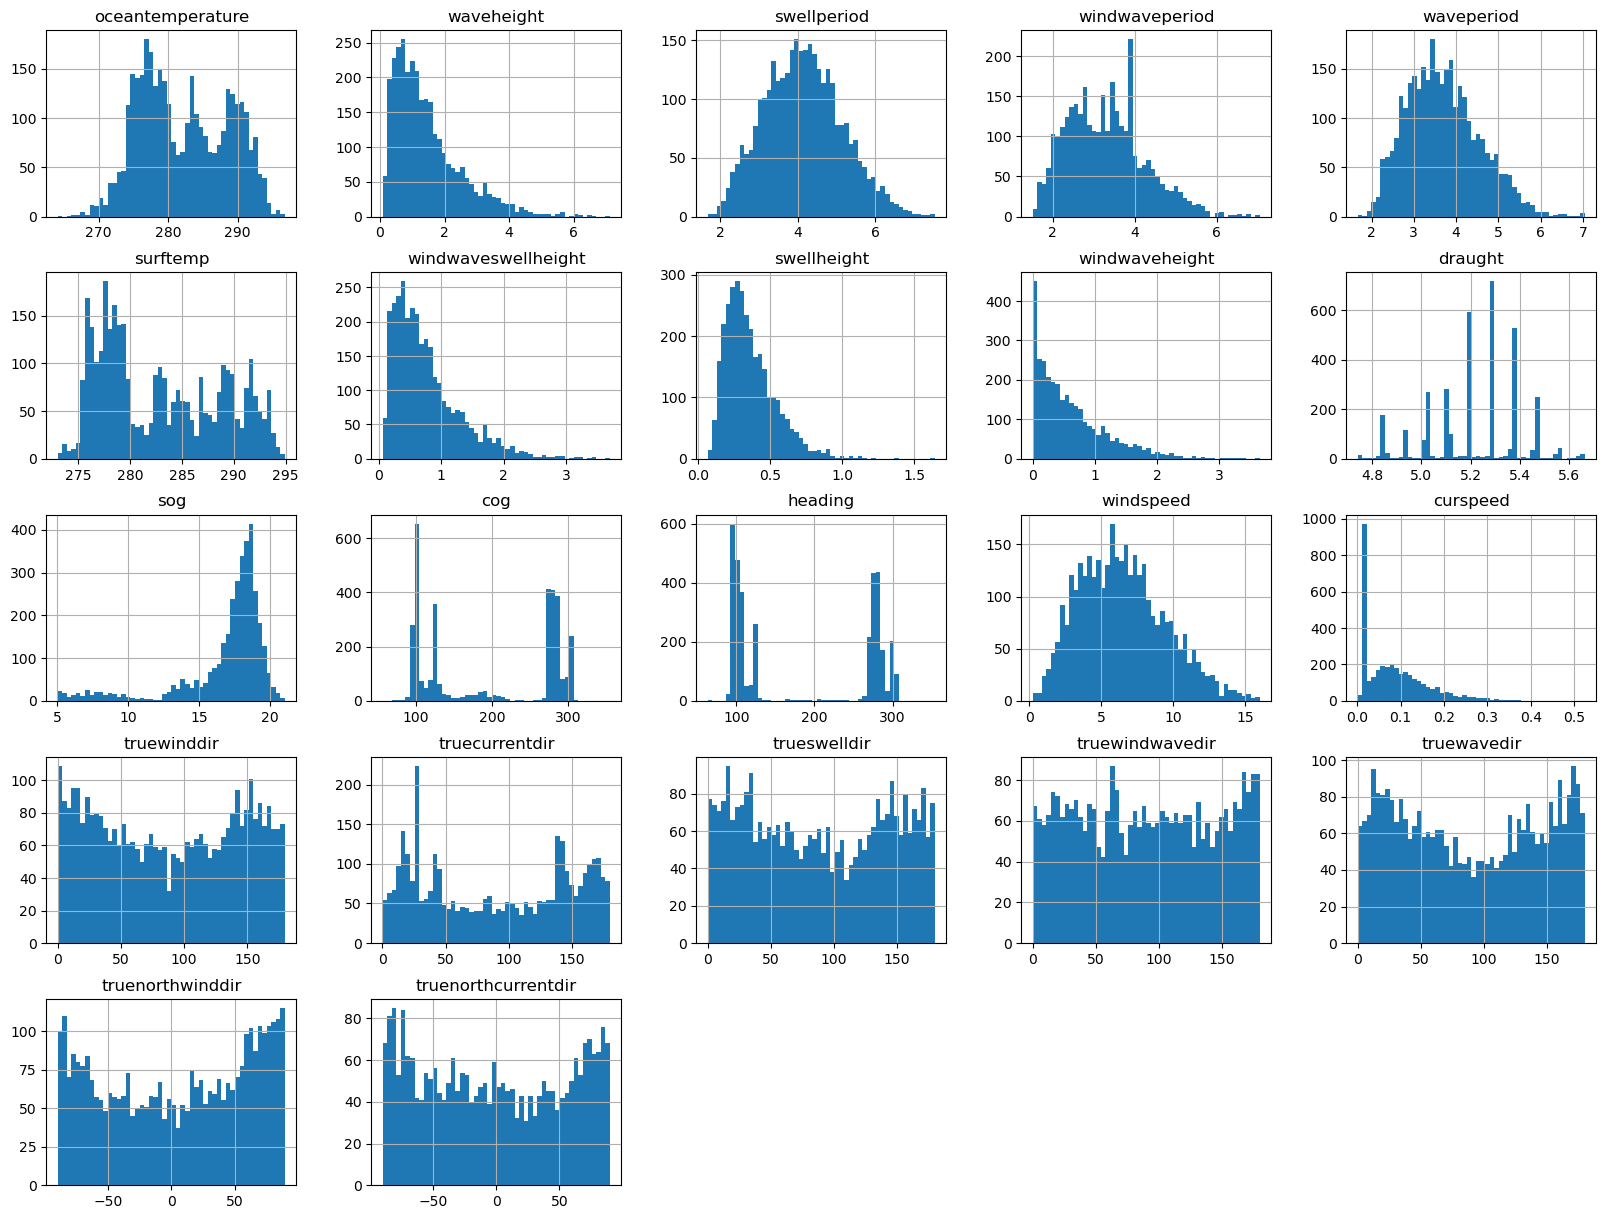

In [262]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
df_ship2.hist(bins=50,figsize=(20,15))
plt.show()

Feature Selection

In [263]:
corr_matrix = df_ship2.corr()
print(corr_matrix["sog"])

oceantemperature       0.066226
waveheight            -0.004305
swellperiod           -0.001119
windwaveperiod        -0.013876
waveperiod             0.002105
surftemp               0.031413
windwaveswellheight   -0.003199
swellheight           -0.020481
windwaveheight        -0.000675
draught                0.148754
sog                    1.000000
cog                    0.016333
heading                0.213539
windspeed              0.117765
curspeed               0.139609
truewinddir            0.063382
truecurrentdir         0.147950
trueswelldir           0.001415
truewindwavedir       -0.003321
truewavedir           -0.006828
truenorthwinddir       0.011171
truenorthcurrentdir    0.005945
Name: sog, dtype: float64


In [264]:
dfship_corr = df_ship2.drop(df_ship2.columns[[0,5,15,16,17,18,19,20,21]],axis=1)
dfship_corr.head()

,waveheight,swellperiod,windwaveperiod,waveperiod,windwaveswellheight,swellheight,windwaveheight,draught,sog,cog,heading,windspeed,curspeed
8,1.661038,4.291309,3.667458,3.757862,0.865413,0.323892,0.801956,5.017723,14.578394,299.573513,269.900574,7.648595,0.104064
9,1.501637,4.187211,3.145607,3.803910,0.785675,0.452440,0.578049,5.019207,18.148696,302.274508,300.130435,6.700397,0.104050
10,1.235528,4.012717,2.120399,3.819602,0.654636,0.556525,0.236435,5.019664,9.686510,163.922318,230.117302,4.089472,0.092759
11,1.204397,4.020009,2.090308,3.820546,0.638782,0.555405,0.226181,5.019009,11.252112,117.003285,178.653615,3.821501,0.093128
12,1.275907,4.095175,3.029945,3.815268,0.674081,0.598373,0.263031,5.020452,18.119627,125.829385,125.446296,5.479353,0.086621


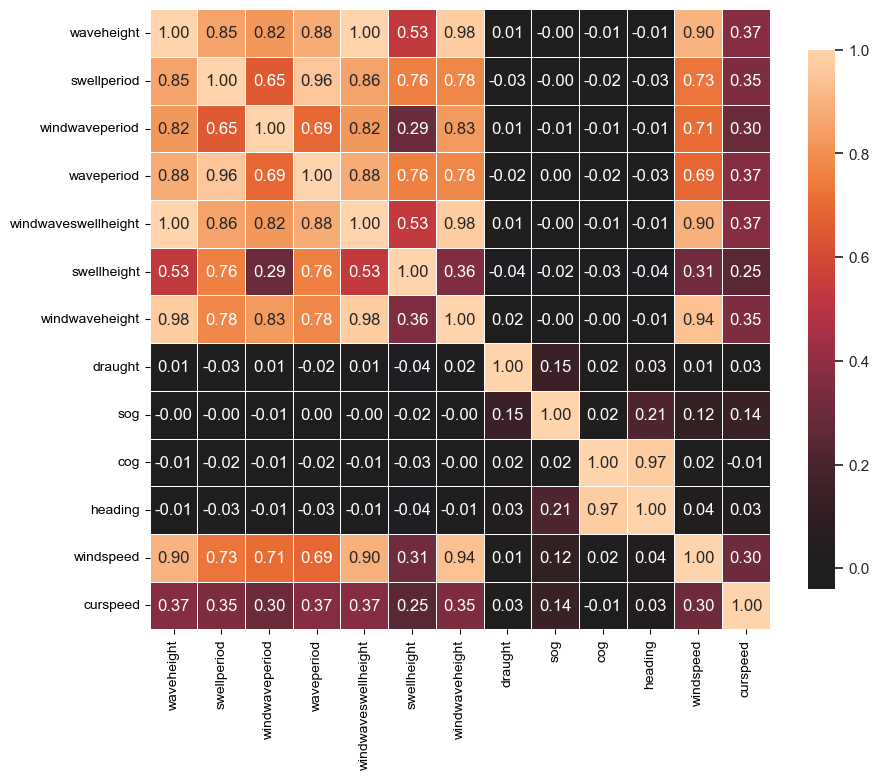

In [265]:
def correlation_heatmap(df,fontsize):
    correlations = df.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.set(font_scale = fontsize)
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_heatmap(dfship_corr,1)

Imputing using KNN so that the Random Forest Regressor may function <br>
RFR cannot accept nan values <br>
Imputed data is then transformed

In [266]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(df_ship2)


KNNImputer(n_neighbors=50)

In [267]:
X = imputer.transform(df_ship2)

In [268]:
df_ship2tr = pd.DataFrame(X, columns=df_ship2.columns, index=df_ship2.index)

In [269]:
print(df_ship2tr.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3506 entries, 8 to 7976
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oceantemperature     3506 non-null   float64
 1   waveheight           3506 non-null   float64
 2   swellperiod          3506 non-null   float64
 3   windwaveperiod       3506 non-null   float64
 4   waveperiod           3506 non-null   float64
 5   surftemp             3506 non-null   float64
 6   windwaveswellheight  3506 non-null   float64
 7   swellheight          3506 non-null   float64
 8   windwaveheight       3506 non-null   float64
 9   draught              3506 non-null   float64
 10  sog                  3506 non-null   float64
 11  cog                  3506 non-null   float64
 12  heading              3506 non-null   float64
 13  windspeed            3506 non-null   float64
 14  curspeed             3506 non-null   float64
 15  truewinddir          3506 non-null   f

Data Split for training and test data

In [270]:
# Implement the Random forest, but first, data is to be split into training and validation data

from sklearn.model_selection import train_test_split

# Dropping some feature can be done here to (possibly) increase the model's performance 

x_train,x_test,y_train,y_test = train_test_split(df_ship2tr.drop(['sog','truenorthcurrentdir','truenorthwinddir']
                                                                 ,axis=1)
                                                                ,df_ship2tr.sog,test_size=0.2,random_state=42)


In [271]:
print("Amount of the x training dataset is:",len(x_train))

Amount of the x training dataset is: 2804


In [272]:
print("Amount of the test dataset is",len(x_test))

Amount of the test dataset is 702


Modelling using Random Forest Regressor 

In [273]:
from sklearn.ensemble import RandomForestRegressor
model_rfr = RandomForestRegressor()
model_rfr.fit(x_train,y_train)

RandomForestRegressor()

Modelling using Decision Tree Regressor

In [274]:
from sklearn.tree import DecisionTreeRegressor
model_dtr = DecisionTreeRegressor()
model_dtr.fit(x_train,y_train)

DecisionTreeRegressor()

Model Evaluation

In [275]:
from sklearn import tree

def tree_visualization(width,height,model_type):
    fn=x_train.columns
    fig, axes = plt.subplots(figsize = (width,height), dpi=800)
    tree.plot_tree(model_type.estimators_[0],
               max_depth=3,
               fontsize=8,
               feature_names = fn);
    plt.show()
    #fig.savefig('rf_individualtree.png')

tree_visualization(25,5,model_rfr)

In [276]:
def model_importance(model_type):
    mod_imp = model_type.feature_importances_
    df_mod_imp = pd.DataFrame(mod_imp,index= x_train.columns,columns=["Importance"])
    print(df_mod_imp)

model_importance(model_rfr)

                     Importance
oceantemperature       0.004500
waveheight             0.002432
swellperiod            0.003155
windwaveperiod         0.004555
waveperiod             0.002799
surftemp               0.004854
windwaveswellheight    0.001984
swellheight            0.006535
windwaveheight         0.002825
draught                0.021765
cog                    0.426837
heading                0.487427
windspeed              0.003086
curspeed               0.006423
truewinddir            0.003385
truecurrentdir         0.005185
trueswelldir           0.005415
truewindwavedir        0.003713
truewavedir            0.003122


Evaluation of RFR

In [277]:
def predict_y(x_test,model_type):
    y_predicted = model_type.predict(x_test)
    return y_predicted

def display_scores(x_test,y_test,model_type):
    from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error
    y_predicted = model_type.predict(x_test)
    print("R^2 score (Indicate model fit. Best Score = 1):", model_type.score(x_test,y_test))
    print("Explained Variance EV (Indicate amount of variance in model. Best Score = 1):", explained_variance_score(y_test,y_predicted))
    print("Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0):", mean_absolute_error(y_test,y_predicted))
    print("Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0):", mean_squared_error(y_test,y_predicted))
    print("Median Absolute Error MAD (Check robustness against outlier. Best Score = 1):", median_absolute_error(y_test,y_predicted))

y_predicted = predict_y(x_test,model_rfr)
display_scores(x_test,y_test,model_rfr)


R^2 score (Indicate model fit. Best Score = 1): 0.9328181446941499
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.932872958708872
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.5546347329650284
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 0.7095480848510665
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.38484635910000087


Evaluation of DTR

In [278]:
y_predicted = predict_y(x_test,model_dtr)
display_scores(x_test,y_test,model_dtr)

R^2 score (Indicate model fit. Best Score = 1): 0.8526085810220092
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.8526260247615258
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.8108982427834758
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 1.5566896535262504
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.5475717149999983


Saving model to local directory

In [279]:
# Saving the model to local directory

filename = 'savemodel_rfr.sav'
joblib.dump(model_rfr,filename)

filename = 'savemodel_dtr.sav'
joblib.dump(model_dtr,filename)

['savemodel_dtr.sav']

Forecasting for June 2021

In [280]:
dfdate6 = dfdate6.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
'Surface pressure','Width','Length'],axis=1)
dfdate6.head(n=5)

,Temperature above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,Combined wind waves and swell height,Swell height,Wind wave height,Draught,...,Heading,Wind Speed,Current Speed,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,True North Wind Direction,True North Current Direction
119,275.823975,3.358080,6.738089,4.925452,5.291555,278.661621,1.759765,0.743164,1.583740,5.281861,...,100.782313,10.248966,0.144914,100.989288,164.871808,15.554049,66.843493,57.268527,21.771601,85.654121
120,275.924011,3.578120,7.185143,5.342444,5.697814,278.936035,1.950242,0.841925,1.757568,5.289403,...,96.934816,11.364678,0.246220,108.737155,153.650411,11.071672,60.455881,51.313932,25.671971,70.585227
121,276.285034,4.184914,7.260825,5.460486,6.126474,279.209961,2.189788,0.933936,1.910706,5.288446,...,97.525758,12.666946,0.284315,114.910729,153.031589,16.281358,57.086511,46.894106,32.436488,70.557348
122,277.189484,4.908680,6.808745,6.225745,6.284671,279.216553,2.565230,0.723303,2.452637,5.290781,...,106.941521,13.386999,0.300428,123.568984,153.643227,69.175152,55.507286,56.527939,50.510505,80.584748
126,277.408752,4.621826,6.813305,5.970984,6.291378,279.319824,2.414834,1.022894,2.130981,4.842367,...,227.680837,12.053293,0.262897,26.476633,41.766758,158.632374,159.050718,167.192888,74.157471,89.447596


In [281]:
dfdate6= dfdate6.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [282]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)

In [283]:
imputer.fit(dfdate6)

KNNImputer(n_neighbors=50)

In [284]:
xdate = imputer.transform(dfdate6)

In [285]:
dfdate6tr = pd.DataFrame(xdate, columns=dfdate6.columns, index=dfdate6.index)

In [286]:
x_date = dfdate6tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
y_date = dfdate6tr.sog

In [287]:
y_predicted = predict_y(x_date,model_rfr)
display_scores(x_date,y_date,model_rfr)


R^2 score (Indicate model fit. Best Score = 1): 0.8655106540790448
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.8856947207468615
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.8174891710427643
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 1.2635660377651237
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.5814641679499957


In [288]:
display_scores(x_date,y_date,model_dtr)


R^2 score (Indicate model fit. Best Score = 1): 0.7682442682455853
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.7941324813971462
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 1.033921553279503
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 2.177411672998958
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.7939773950000006


In [289]:
ydate_pred = y_predicted
dfprog_sog = pd.Series(y_date,name="sog_act").to_frame()
dfprog_sog["sog_pred"] = ydate_pred
dfprog_sog["truenorthcurrentdir"] = dfdate6tr["truenorthcurrentdir"]
dfprog_sog["truenorthwinddir"] = dfdate6tr["truenorthwinddir"]

print(dfprog_sog)

        sog_act   sog_pred  truenorthcurrentdir  truenorthwinddir
119   18.998906  18.532150            85.654121         21.771601
120   19.334278  18.507278            70.585227         25.671971
121   18.911047  18.629329            70.557348         32.436488
122   13.854933  13.987405            80.584748         50.510505
126    9.305198  10.829396            89.447596         74.157471
...         ...        ...                  ...               ...
7413  19.072622  18.308065           -75.033834        -69.040073
7414  17.696584  17.661892            86.330174        -53.162661
7415  15.963630  16.482205            83.486098        -60.981379
7418   8.988086   8.568891           -15.412087        -39.276623
7419  17.672769  17.378516             1.124001        -36.097446

[322 rows x 4 columns]


In [290]:
dfprog = pd.concat([x_date,dfprog_sog],axis=1)
dfprog.head(n=10)

,oceantemperature,waveheight,swellperiod,windwaveperiod,waveperiod,surftemp,windwaveswellheight,swellheight,windwaveheight,draught,...,curspeed,truewinddir,truecurrentdir,trueswelldir,truewindwavedir,truewavedir,sog_act,sog_pred,truenorthcurrentdir,truenorthwinddir
119,275.823975,3.358080,6.738089,4.925452,5.291555,278.661621,1.759765,0.743164,1.583740,5.281861,...,0.144914,100.989288,164.871808,15.554049,66.843493,57.268527,18.998906,18.532150,85.654121,21.771601
120,275.924011,3.578120,7.185143,5.342444,5.697814,278.936035,1.950242,0.841925,1.757568,5.289403,...,0.246220,108.737155,153.650411,11.071672,60.455881,51.313932,19.334278,18.507278,70.585227,25.671971
121,276.285034,4.184914,7.260825,5.460486,6.126474,279.209961,2.189788,0.933936,1.910706,5.288446,...,0.284315,114.910729,153.031589,16.281358,57.086511,46.894106,18.911047,18.629329,70.557348,32.436488
122,277.189484,4.908680,6.808745,6.225745,6.284671,279.216553,2.565230,0.723303,2.452637,5.290781,...,0.300428,123.568984,153.643227,69.175152,55.507286,56.527939,13.854933,13.987405,80.584748,50.510505
126,277.408752,4.621826,6.813305,5.970984,6.291378,279.319824,2.414834,1.022894,2.130981,4.842367,...,0.262897,26.476633,41.766758,158.632374,159.050718,167.192888,9.305198,10.829396,89.447596,74.157471
127,277.399658,3.852527,6.907508,5.299354,6.061778,279.230591,2.021695,1.143225,1.607422,4.841530,...,0.181460,49.650197,36.203894,98.603207,126.285782,119.939682,20.935741,17.424789,85.735437,72.289134
128,275.499359,3.304548,6.816074,4.561194,5.927387,286.705762,1.754722,1.136414,1.240662,4.852890,...,0.281402,11.124505,16.745666,170.252415,173.337517,176.253205,12.419853,12.235935,87.870444,60.000273
130,276.370789,2.999140,6.680770,3.821632,5.959699,286.763584,1.585114,1.306714,0.837463,4.923635,...,0.185268,121.750507,148.640604,55.948144,59.314576,54.778275,20.447721,16.448165,-84.704755,68.405148
131,277.268555,3.283719,6.891045,4.686806,5.876345,279.216553,1.731217,1.167188,1.231018,4.925344,...,0.133047,156.811217,154.901600,57.732440,24.484072,41.385363,18.702889,16.465161,82.800757,84.710374
134,277.220703,2.827531,6.624643,4.262856,5.585643,279.216553,1.490863,1.038464,1.032349,5.202804,...,0.139192,1.584058,10.961510,144.135380,178.761731,159.775304,16.155258,16.377091,-78.378834,89.075598


In [291]:
dfprog["vgms"] = dfprog["sog_pred"]/1.9438

In [292]:
dfprog["vgx"] = dfprog["vgms"] * np.sin(np.deg2rad(dfprog["cog"]))
dfprog["vcx"] = dfprog["curspeed"] * np.sin(np.deg2rad(dfprog["truenorthcurrentdir"]))
dfprog["stw_x"] = (dfprog["vgx"] - dfprog["vcx"])

In [293]:
dfprog["vgy"] = dfprog["vgms"] * np.cos(np.deg2rad(dfprog["cog"]))
dfprog["vcy"] = dfprog["curspeed"] * np.cos(np.deg2rad(dfprog["truenorthcurrentdir"]))
dfprog["stw_y"] = (dfprog["vgy"] - dfprog["vcy"])

In [294]:
dfprog["vwms_p"] = np.sqrt(dfprog["stw_x"]**2 + dfprog["stw_y"]**2)
dfprog["stw_pred"] = dfprog["vwms_p"]*1.9438
dfprog = dfprog.drop(['vgms','vgx','vcx','stw_x',
                      'vgy','vcy','stw_y',
                      'vwms_p'],axis=1)
#df_ship.head(n=5)
dfprog.head(n=10)

,oceantemperature,waveheight,swellperiod,windwaveperiod,waveperiod,surftemp,windwaveswellheight,swellheight,windwaveheight,draught,...,truewinddir,truecurrentdir,trueswelldir,truewindwavedir,truewavedir,sog_act,sog_pred,truenorthcurrentdir,truenorthwinddir,stw_pred
119,275.823975,3.358080,6.738089,4.925452,5.291555,278.661621,1.759765,0.743164,1.583740,5.281861,...,100.989288,164.871808,15.554049,66.843493,57.268527,18.998906,18.532150,85.654121,21.771601,18.263222
120,275.924011,3.578120,7.185143,5.342444,5.697814,278.936035,1.950242,0.841925,1.757568,5.289403,...,108.737155,153.650411,11.071672,60.455881,51.313932,19.334278,18.507278,70.585227,25.671971,18.086519
121,276.285034,4.184914,7.260825,5.460486,6.126474,279.209961,2.189788,0.933936,1.910706,5.288446,...,114.910729,153.031589,16.281358,57.086511,46.894106,18.911047,18.629329,70.557348,32.436488,18.148146
122,277.189484,4.908680,6.808745,6.225745,6.284671,279.216553,2.565230,0.723303,2.452637,5.290781,...,123.568984,153.643227,69.175152,55.507286,56.527939,13.854933,13.987405,80.584748,50.510505,13.409203
126,277.408752,4.621826,6.813305,5.970984,6.291378,279.319824,2.414834,1.022894,2.130981,4.842367,...,26.476633,41.766758,158.632374,159.050718,167.192888,9.305198,10.829396,89.447596,74.157471,10.532619
127,277.399658,3.852527,6.907508,5.299354,6.061778,279.230591,2.021695,1.143225,1.607422,4.841530,...,49.650197,36.203894,98.603207,126.285782,119.939682,20.935741,17.424789,85.735437,72.289134,17.710532
128,275.499359,3.304548,6.816074,4.561194,5.927387,286.705762,1.754722,1.136414,1.240662,4.852890,...,11.124505,16.745666,170.252415,173.337517,176.253205,12.419853,12.235935,87.870444,60.000273,12.570038
130,276.370789,2.999140,6.680770,3.821632,5.959699,286.763584,1.585114,1.306714,0.837463,4.923635,...,121.750507,148.640604,55.948144,59.314576,54.778275,20.447721,16.448165,-84.704755,68.405148,16.747957
131,277.268555,3.283719,6.891045,4.686806,5.876345,279.216553,1.731217,1.167188,1.231018,4.925344,...,156.811217,154.901600,57.732440,24.484072,41.385363,18.702889,16.465161,82.800757,84.710374,16.233139
134,277.220703,2.827531,6.624643,4.262856,5.585643,279.216553,1.490863,1.038464,1.032349,5.202804,...,1.584058,10.961510,144.135380,178.761731,159.775304,16.155258,16.377091,-78.378834,89.075598,16.108414
